In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tfd = tf.contrib.distributions

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
def make_encoder(data, code_size):
  x = tf.layers.flatten(data)
  x = tf.layers.dense(x, 256, tf.nn.relu)
  x = tf.layers.dense(x, 256, tf.nn.relu)
  loc = tf.layers.dense(x, code_size)
  scale = tf.layers.dense(x, code_size, tf.nn.softplus)
  return tfd.MultivariateNormalDiag(loc, scale)

In [3]:
def make_prior(code_size):
  loc = tf.zeros(code_size)
  scale = tf.ones(code_size)
  return tfd.MultivariateNormalDiag(loc, scale)

In [4]:
def make_decoder(code, data_shape):
  x = code
  x = tf.layers.dense(x, 256, tf.nn.relu)
  x = tf.layers.dense(x, 256, tf.nn.relu)
  logit = tf.layers.dense(x, np.prod(data_shape))
  logit = tf.reshape(logit, [-1] + data_shape)
  return tfd.Independent(tfd.Bernoulli(logit), 2) # we do not binarise MNIST -> not Bernoulli

In [5]:
def plot_codes(ax, codes, labels):
  ax.scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1)
  ax.set_aspect('equal')
  ax.set_xlim(codes.min() - .1, codes.max() + .1)
  ax.set_ylim(codes.min() - .1, codes.max() + .1)
  ax.tick_params(
      axis='both', which='both', left='off', bottom='off',
      labelleft='off', labelbottom='off')


def plot_samples(ax, samples):
  for index, sample in enumerate(samples):
    ax[index].imshow(sample, cmap='gray')
    ax[index].axis('off')

In [6]:
# for reusage of network with trainable parameters
make_encoder = tf.compat.v1.make_template('encoder', make_encoder)
make_decoder = tf.compat.v1.make_template('decoder', make_decoder)


ELBO loss: $\[\ln p(x)\geq\mathbb{E}_{q(z|x)}[\ln p(x|z)]-D_{KL}[q(z|x)||p(z)]\]$

In [7]:
data = tf.compat.v1.placeholder(tf.float32, [None, 28, 28])

# define the model
prior = make_prior(code_size=2)
posterior = make_encoder(data, code_size=2)
code = posterior.sample()

# define the loss
likelihood = make_decoder(code, [28, 28]).log_prob(data)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlo

In [8]:
optimize = tf.compat.v1.train.AdamOptimizer(0.001).minimize(-elbo)

In [9]:
samples = make_decoder(prior.sample(10), [28, 28]).mean()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch 0 elbo -543.3626
Epoch 1 elbo -168.91304
Epoch 2 elbo -162.5272
Epoch 3 elbo -157.63858
Epoch 4 elbo -154.55376
Epoch 5 elbo -152.19577
Epoch 6 elbo -151.09007
Epoch 7 elbo -149.75885
Epoch 8 elbo -149.04868
Epoch 9 elbo -147.47356
Epoch 10 elbo -146.76915
Epoch 11 elbo -146.61646
Epoch 12 elbo -145.73863
Epoch 13 elbo -145.34148
Epoch 14 elbo -144.70738
Epoch 15 elbo -143.81335
Epoch 16 elbo -144.1019
Epoch 17 elbo -143.42905
Epoch 18 elbo -143.6044
Epoch 19 elbo -143.26462


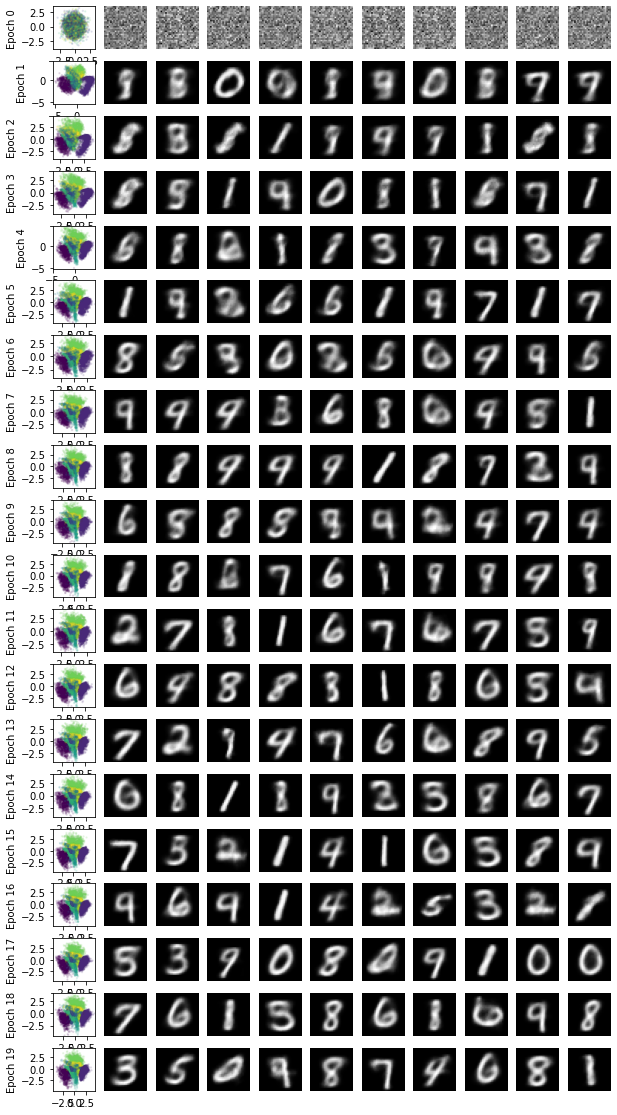

In [11]:
# load data
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data/')

fig, ax = plt.subplots(nrows=20, ncols=11, figsize=(10, 20))
with tf.train.MonitoredSession() as sess:
  for epoch in range(20):
    feed = {data: mnist.test.images.reshape([-1, 28, 28])}
    test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], feed)
    print('Epoch', epoch, 'elbo', test_elbo)
    ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))
    plot_codes(ax[epoch, 0], test_codes, mnist.test.labels)
    plot_samples(ax[epoch, 1:], test_samples)
    for _ in range(600):
      feed = {data: mnist.train.next_batch(100)[0].reshape([-1, 28, 28])}
      sess.run(optimize, feed)
plt.savefig('vae-mnist.png', dpi=300, transparent=True, bbox_inches='tight')

source:
@misc{hafner2018tfdistvae,
  author = {Hafner, Danijar},
  title = {Building Variational Auto-Encoders in TensorFlow},
  year = {2018},
  howpublished = {Blog post},
  url = {https://danijar.com/building-variational-auto-encoders-in-tensorflow/}
}